# Data preparation with reporting torchIO errors
Due to the problem with IO.stream redirecting in Jupyter Notebook, most of the code run outside of the notebook, from `dataset_creation.py` file.

## Creating a configurational file
At the begining pylidc library needs a configurational file `.pylidcrc` saved at the root directory. File have to include path to LIDC-IDRI dataset.

In [39]:
! pwd

/lu/tetyda/home/dzban112/Lung_cancer


In [40]:
path = '../LIDC_sets/10_hundred/LIDC-IDRI'
with open('/home/dzban112/.pylidcrc', 'w') as f: # mode 'w' clear file and starts writing from the begining.
    f.write(f'[dicom]\npath = {path}\n\n')

In [41]:
! cat /home/dzban112/.pylidcrc

[dicom]
path = ../LIDC_sets/10_hundred/LIDC-IDRI



## Defining base path and saving path
Base path is a path to the LIDC-IDRI set. <br/>
Saving path is where the prepared dataset will be saved.

In [3]:
# define path to LIDC-IDRI data
base_path = "../LIDC_sets/10_hundred/LIDC-IDRI"
# define path to save the dataset
save_path = "./dataset"

with open('paths.txt', 'w') as p:
    p.write(base_path + "\n")
    p.write(save_path)

## What data is extracted from LIDCI-IDRI set?
The scope of this notebook is to extract relevant data from the big LIDCI-IDRI set. Whole dataset include **1018** records, which are CT (Computer Tomography) scans of patients lungs.
Scans are annotated by maximally **4** annotators. Each annotation corresponds to a nodule and describes its attributes. For purpose of dataset creation I extracted following nodule attributes:
* sublety
* internalStructure
* calcification
* sphericity
* margin
* lobulation
* spiculation
* texture
* diameter

There is also hand-crafted target feature, which says whether nodule in benign or malignant.
Last but not the least, image data is extracted by cropping original scans. Only volume of dimmensions **(h, h, h)** which surrounds center of nodule is extracted. **Parameter h is set by default to 32.** It may be adjusted in `dataset_creation.py` file.

### Main script
Running it creates dataset with extracted values. Code makes following files:
* `{save_path}/match.pkl` - 2D array with matched LIDCI-IDRI patient ID and new nodule ID in the created dataset. 
* `{save_path}/annotations.pkl` - python dictionary object with annotations data saved as pickle file.
* `{save_path}/annotations_df.pkl` - Pandas DataFrame object with annotations data saved as pickle file.
<br/> Also following directories are prepared:
* `{save_path}/crops` - directory stores extracted image volumes with nodules.
* `{save_path}/masks` - directory stores corresponding to volumes masks.

Script accept additional argument indicating starting idx for nodules.
It is because I cannot download all data on disk and I have to download and process it in batches ;)

In [43]:
! python3 dataset_creation.py --start_idx 771 --ann_output_filename annotations_10 --match_table_name match_10

 35%|██████████████▉                           | 39/110 [05:25<10:29,  8.87s/it]Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
skipping!
100%|█████████████████████████████████████████| 110/110 [14:28<00:00,  7.90s/it]


In [44]:
import pickle
import pandas as pd

FILENAME = "annotations_10"

# Creates pandas dataframe from dictionary and saves it as pickle
with open(f"{save_path}/{FILENAME}.pkl", "rb") as k:
    avg_annotations = pickle.load(k)
df_ann = pd.DataFrame.from_dict(avg_annotations)
df_ann.to_pickle(f"{save_path}/{FILENAME}_df.pkl")

In [45]:
df_ann.head()

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,diameter,target,path
0,4.333333,1.0,6.0,3.333333,3.000000,2.666667,4.00,4.0,11.709594,1,0771.pt
1,4.250000,1.0,6.0,3.500000,4.000000,2.250000,2.75,5.0,13.820808,1,0772.pt
2,3.000000,1.0,6.0,4.333333,4.666667,1.000000,1.00,5.0,5.107378,0,0773.pt
3,3.250000,1.0,6.0,4.000000,3.750000,1.250000,1.50,4.0,5.992543,0,0774.pt
4,2.500000,1.0,6.0,3.500000,3.000000,1.500000,1.00,2.5,8.304337,0,0775.pt


## Concatenating DataFrames
As I downloaded and processed CT scans in batches, at the end I concatenate intermediate DataFrames into one final.

In [2]:
import pickle
import pandas as pd

df = pd.read_pickle(f"{save_path}/annotations_1_df.pkl")

for i in range(2, 11):
    df_next = pd.read_pickle(f"{save_path}/annotations_{i}_df.pkl")
    df = pd.concat([df, df_next], ignore_index=True, axis=0)

In [6]:
df.to_pickle(f"{save_path}/ALL_annotations_df.pkl")

## Visualisation of crops
Below function to visualise crops slices

In [1]:
import matplotlib.pyplot as plt
import torch

plt.set_cmap('gray')

def visualise_crop_slice(save_path, ID, slice_number, apply_mask = True):
    crop = torch.load(f"{save_path}/crops/{ID}")
    mask = torch.load(f"{save_path}/masks/{ID}")
    
    if apply_mask:
        img = crop*mask
    else:
        img = crop
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img[:,:,slice_number])
    plt.show()

<Figure size 432x288 with 0 Axes>

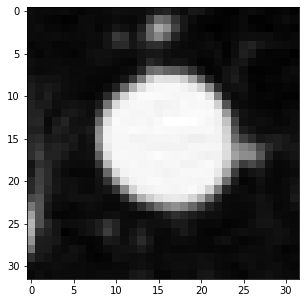

In [8]:
visualise_crop_slice(save_path, "0347.pt", 16, apply_mask=False)